### IMPORTS 

In [11]:
# LIRBARIES ------
import warnings

warnings.filterwarnings("ignore")

import multiprocessing

# Misc
import os
import shutil
from datetime import datetime

# Combinatorics
from itertools import product
from pickle import dump, load

# Matrices
import numpy as np

# DF
import pandas as pd

# Boosting machine
import xgboost as xgb
from IPython.display import Markdown as md
from IPython.display import display as printmd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer

# metrics
from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    mean_squared_log_error,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR

# regression


# utils
base_path = "/home/jovyan/work/TP3_TP4"  # laptop : /home/jovyan/work/CM_ML/TP3_TP4 other tower: /home/jovyan/work/TP3_TP4
os.chdir(base_path)

import sys

# sys.path.append(os.path.join(base_path,"utils"))
sys.path.append(base_path)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

# Plots
import seaborn as sns
from plotly import graph_objects as go
from sklearn.tree import plot_tree
from utils.utils import rmsle_scorer

# pio.renderers.default='notebook'

dataset = "bill"
pd.set_option("display.float_format", lambda x: "%.5f" % x)

### PATHS TO FOLDERS 

In [12]:
# FOLDERS TO STORE ------
paths_to_create = [
    os.path.join(base_path, "scale_dump"),
    os.path.join(base_path, "model_dump"),
    os.path.join(base_path, "grid_search"),
    os.path.join(base_path, "Old_"),
]

### PATH TO FILES 

In [13]:
# --- --- --- FOLDERS AND FILES --- --- ---
# * Data path ---
data_path = os.path.join(base_path, "data")

# * House dataset paths ---
house_train = os.path.join(data_path, "house", "train.csv")

# * Bills dataset paths ---
bill_train = os.path.join(data_path, "bills","bill_authentication.csv")

# * Wine dataset paths ---
wine_train = os.path.join(data_path, "wine","winequality-red.csv")

### IMPORT DATA 

In [14]:
# --- --- --- DATA --- --- ---
# * Load house data ---
bill = pd.read_csv(bill_train, sep=";")

### HELPER FUNCTIONS 

In [15]:
def preprocess_data_as_model(data, dependent, categorical):
    # * Divide X,y ---
    data_subset = data.drop(dependent, axis=1)
    y = data[dependent].values

    # handle categorical variables ---
    cols_beginning = data_subset.columns.values

    all_cols = cols_beginning
    numeric_cols = data_subset.select_dtypes(["number"]).columns
    numeric_cols_index = np.in1d(all_cols, numeric_cols)

    categorical_cols = data_subset.select_dtypes(["object"]).columns
    categorical_cols_index = np.in1d(all_cols, categorical_cols)

    # Transformations ---
    transformations = []

    if categorical:
        pass  # todo
    else:
        # Training cols ---
        data_subset = data_subset.select_dtypes(["number"])  # drop categorical
        all_cols = cols_beginning[numeric_cols_index]  # only numerical cols ....
        numeric_cols_index = (
            data_subset.columns.values != None
        )  # apply transformation to all columns
    return (data_subset, y, all_cols)


def load_scores(base_path, models):
    score_list = []
    loaded_models = {}
    for model in models:
        with open(os.path.join(base_path, model), "rb") as trained_model:
            loaded = load(trained_model)
            loaded_models[model]=loaded
        try:
            scores = loaded["scores"]
            meta = model.split("_")

            scores["raw_path"] = model
            scores["model"] = meta[0]
            scores["dataset"] = meta[1]
            scores["kind"] = meta[2]

            score_list.append(scores)
        except:
            print("model without scores")
    return score_list, loaded_models

### IMPORT ALL MODELS 

In [16]:
# list all models ---
models = list(os.walk(paths_to_create[1]))[0][2]

print("--- --- LOADING ALL MODELS --- ---")
score_list, loaded_models = load_scores(paths_to_create[1], models)
print(f"Number of model : {len(loaded_models)}")

print("--- --- SCORES TO DF --- ---")
scores = pd.concat(score_list)
scores.reset_index(inplace=True)
scores.rename(columns={"index": "metric"}, inplace=True)
scores = scores.melt(
    id_vars=["metric", "raw_path", "model", "dataset", "kind", "difference"],
    var_name="data_split",
    value_name="score",
)

scores = scores.query("dataset == @dataset")

scores.head()

--- --- LOADING ALL MODELS --- ---
Number of model : 31
--- --- SCORES TO DF --- ---


,metric,raw_path,model,dataset,kind,difference,data_split,score
0,accuracy,rf_bill_grid_squared_error_True_-0.00582_06-02...,rf,bill,grid,0.00471,train,0.99899
1,f1,rf_bill_grid_squared_error_True_-0.00582_06-02...,rf,bill,grid,0.00492,train,0.99885
8,accuracy,rf_bill_baseline_squared_error_True_-0.00275_0...,rf,bill,baseline,0.00571,train,1.00000
9,f1,rf_bill_baseline_squared_error_True_-0.00275_0...,rf,bill,baseline,0.00606,train,1.00000
13,accuracy,svm_bill_grid_misclassification_True_0.0_06-02...,svm,bill,grid,0.00000,train,1.00000


### VISUALISATION DE LA PERFORMACE DES MODÈLES

Nous voulons visualiser la performance des modèles. 

Nous avons calculé 3 métriques par modèle: 
- RMSLE (la métrique utilisée par kaggle pour la compétition des prix des maisons)
- MAE
- RMSE

Chaque modèle a été entraîner au minimum deux fois: 
- baseline (sans hyperparamètres)
- Grid search 

Les modèles avec *feature importances* (*Random Forest* et *XGB*) possèdent un troisième *fit* effectué uniquement sur les attributs significatifs. Ce dernier fit utilise aussi un grid search.
- refit

Les trois métriques mentionnées ont été calculées pour les 3 échantillons de données (*train*, *validation*, *test*).
Aucun modèle n'a jamais vu les données de test (même pas pour du *early stopping*).

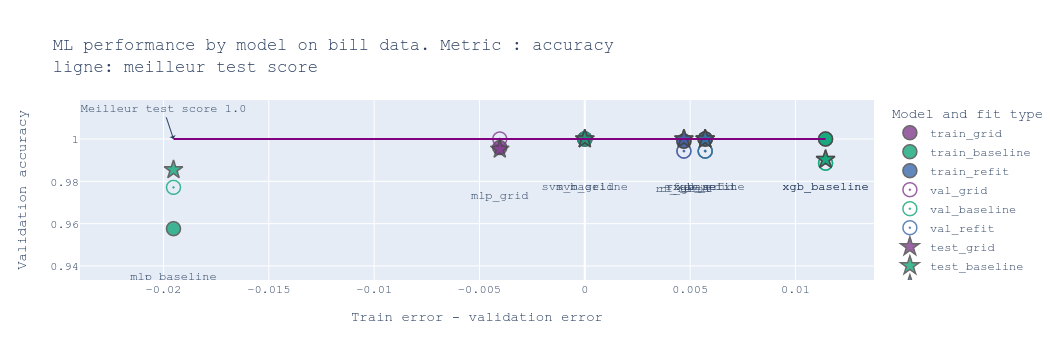

In [18]:
subset = scores.query("metric=='accuracy'")
fig = go.Figure()
symbols = ["circle", "circle-open-dot", "star"]
colors = ["#EF553B", "#FECB52", "#00CC96"]
colors = px.colors.qualitative.Bold

# Add traces
show_anot = 0
for ith, split in enumerate(["train", "val", "test"]):
    temp = subset.query("data_split==@split")

    for i, kind in enumerate(temp["kind"].unique()):
        color = colors[i]
        models = temp[temp["kind"] == kind]["model"].values
        fig.add_trace(
            go.Scatter(
                x=temp[temp["kind"] == kind]["difference"],
                y=temp[temp["kind"] == kind]["score"],
                mode="markers",
                name=split + "_" + kind,
                marker=dict(
                    size=14,
                    symbol=symbols[ith],
                    color=color,
                    opacity=0.8,
                    line=dict(width=1.5),
                ),
                text=models + "_" + kind,
                hovertemplate="train error - val accuracy: %{x} <br> SCORE: %{y} </br> MODEL :%{text}",
            )
        )

        if show_anot == 0:
            fig.add_trace(
                go.Scatter(
                    x=temp[temp["kind"] == kind]["difference"],
                    y=temp[temp["kind"] == kind]["score"] - 0.02,
                    mode="text",
                    text=models + "_" + kind,
                    textposition="bottom center",
                    showlegend=False,
                )
            )
    show_anot += 1
    
fig.add_shape(type='line',
                x0=np.min(subset['difference']),
                y0=np.max(subset.query("data_split=='test'")['score']),
                y1=np.max(subset.query("data_split=='test'")['score']),
                x1=np.max(subset['difference']),
                line=dict(color='Purple',),
                xref='x',
                yref='y'
                
)

best_score= np.max(subset.query("data_split=='test'")['score'])
fig.add_annotation(text= f"Meilleur test score {np.round(best_score,6)}",
                  x=np.min(subset['difference']), y=best_score, showarrow=True,arrowhead=1)

fig.update_layout(
    title=f"ML performance by model on {dataset} data. Metric : accuracy <br>ligne: meilleur test score </br>",
    xaxis_title="Train error - validation error",
    yaxis_title="Validation accuracy",
    legend_title="Model and fit type",
    font=dict(family="Courier New, monospace", size=12),
)

fig.show()

Tous les modèles avec *hyperparameter tuning* obtiennent des résultats près de 1 ou de 1. 

Les modèles qui obtiennent une accuracy de 1 sont: 
- Les SVM
- XGB tuned, refit
- RF tuned, refit, baseline

Le seul modèle qui est loin (relativement) du meilleur score est le MLP baseline. 

Nous pouvons essayer de comprendre pourquoi en regardant ses paramètres.

In [23]:
scores["abs_difference"]= np.abs(scores["difference"])
scores.sort_values("abs_difference", inplace=True)
worst_models= scores.query("data_split=='test'")["raw_path"][-1:]

In [26]:
print("--- Worst models ---")

worst_models

--- Worst models ---


180    mlp_bill_baseline_mae_True_-0.01098_06-02-2022...
Name: raw_path, dtype: object

Voici les parametres de chaque modèle 

In [27]:
for model_to_query in worst_models:
    print(model_to_query)
    print(loaded_models.get(model_to_query).get("model").get_params())
    print("\n")

mlp_bill_baseline_mae_True_-0.01098_06-02-2022_21:11:43.pkl
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 3000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 123, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}




La régularisation est très faible et il y une seule couche intermédiaire.

Les meilleurs modèles:


In [42]:
scores["abs_difference"]= np.abs(scores["difference"])
scores.sort_values("abs_difference", inplace=True)
best_models= scores.query("data_split=='test' & metric == 'accuracy'")["raw_path"][:6]
print(best_models)

206    svm_bill_baseline_misclassification_True_-0.0_...
177    svm_bill_grid_misclassification_True_0.0_06-02...
223    mlp_bill_grid_mae_True_-0.01616_06-02-2022_21:...
164    rf_bill_grid_squared_error_True_-0.00582_06-02...
196    rf_bill_refit_squared_error_True_-0.00582_06-0...
192    xgb_bill_refit_reg:squarederror_True_-0.00097_...
Name: raw_path, dtype: object


L'algorithme SVM semble être très pertinent pour ce dataset (il obtient de très bons résultats même sans *tuning*).

Le MLP rejoint la liste grâce à la recherche de paramètres. De même pour les Random Forests. 

### GRID SEARCH PARAMS 

Nous pouvons visualiser la recherche de paramètres pour le MLP:

In [37]:
grids = list(os.walk(paths_to_create[2]))[0][2]

import re 
grids=[i for i in grids if re.search("bill",i)]

grid=pd.read_csv(os.path.join(paths_to_create[2],grids[0]))


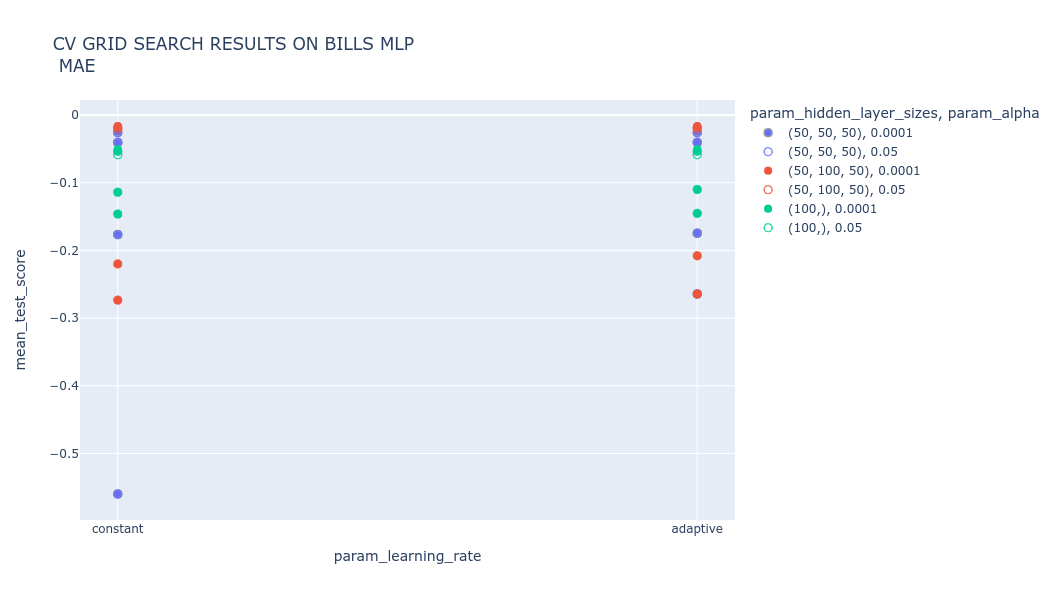

In [40]:
# VIZ RESULTS ------ 
res=pd.DataFrame(grid);

fig=px.scatter(res,x="param_learning_rate", y ="mean_test_score", color= "param_hidden_layer_sizes", symbol= "param_alpha", 
               symbol_sequence=["circle","circle-open"],
               title= "CV GRID SEARCH RESULTS ON BILLS MLP <br> MAE")
fig.update_traces(marker={'size': 8})
fig.update_layout(height=600)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=-0.2,
                                          ticks="outside"))

fig["data"][0]["marker"]["line"]={"color":"#9f9f9f", "width":1.5}
fig

Parmi les meilleurs combinaisons (rouge en haut), il semblerait que ajouter des couches intermédiares augemente l'accuracy du modèle (en test). Les autres variations sont du aux autres paramètres de la recherche (*solver* et *activation function*)

### XGBOOST PERFORMANCE 

In [51]:
xgboost_grid= loaded_models.get(best_models.tolist()[5]).get("model")
val_metrics= xgboost_grid.evals_result()['validation_0']["rmsle"]
nboosted=len(val_metrics)
best_iter=xgboost_grid.best_iteration
best_score = xgboost_grid.best_score
md(f"Nous voyons que le early stopping a fonctionné. En effet, le booster a été initialisé avec 600 pas (steps), mais en réalité il en a effectué que {nboosted}.<br> \
Ce qui veut dire que la meilleure itération n'est pas la dernière: l'erreur minimale avec les données de validation a été obtenue à l'itération {best_iter}")

Nous voyons que le early stopping a fonctionné. En effet, le booster a été initialisé avec 600 pas (steps), mais en réalité il en a effectué que 470.<br> Ce qui veut dire que la meilleure itération n'est pas la dernière: l'erreur minimale avec les données de validation a été obtenue à l'itération 459

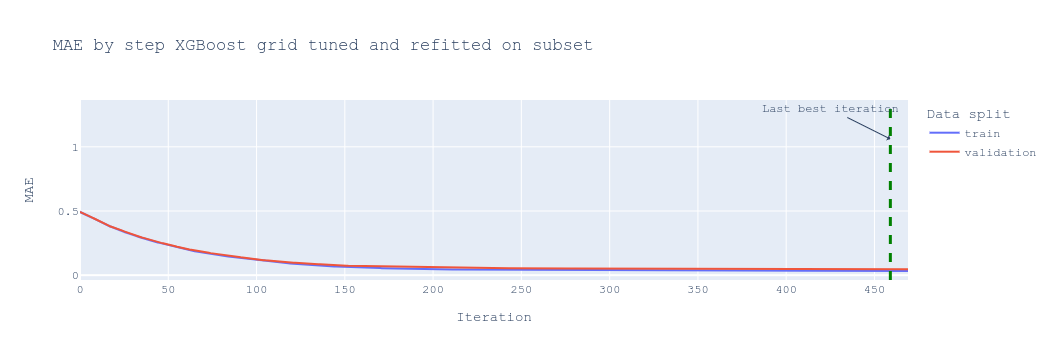

In [52]:
fig = go.Figure()
keys= ['validation_0','validation_1']
# Add traces
step_data=[]
for i, data_split in enumerate(['train','validation']):
    data_split_= keys[i]
    color = colors[i]
    step_score=xgboost_grid.evals_result()[data_split_]["mae"]
    fig.add_trace(
        go.Scatter(
            y= step_score,
            mode="lines",
            name= data_split,
        )
    )
    step_data.append(step_score)
    
fig.add_annotation(x=best_iter, y=best_score+1, ax=-60,
        text="Last best iteration",
        showarrow=True,
        arrowhead=1)
    
fig.update_layout(
    title=f"MAE by step XGBoost grid tuned and refitted on subset",
    xaxis_title="Iteration",
    yaxis_title="MAE",
    legend_title="Data split ",
    font=dict(family="Courier New, monospace", size=12),
)
fig.add_vline(
    x=best_iter, line_width=3, line_dash="dash", 
    line_color="green")

fig.show()

L'apprentissage est rapide, 150 itérations sont nécessaires pour obtenir un taux d'erreur très bas (il diminue très longtement après). 